In [15]:
import sys
from astropy.io import ascii
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from astropy.table import QTable, Table, Column
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import time, coordinates as coord, units as u
from astropy.table import Table, hstack
from astropy.io import fits
from astropy.visualization import ZScaleInterval as zscale

os.chdir("/home/sumedha/Documents/Gaia-ML-Expt/1_to_15_sep/gaia")

# # Run once to combine all csv files

# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
# combined_csv.to_csv( "gaia_1to15_sep.csv", index=False, encoding='utf-8-sig')

# Reading in the Observed Data Files
gaia_data = ascii.read('/home/sumedha/Documents/Gaia-ML-Expt/1_to_15_sep/gaia/gaia_1to15_sep.csv')
all_gaia_data = ascii.read('/home/sumedha/Documents/Gaia-ML-Expt/all_gaia_data/gaia_all_data.csv')
ml_data = ascii.read('/home/sumedha/Documents/Gaia-ML-Expt/1_to_15_sep/meerzicht_imagesearch_20211021T082534.csv')
mlbg_ids = ascii.read('/home/sumedha/Documents/Gaia-ML-Expt/ML_FieldIDs_complete_equatorial_true-ecliptic_galactic.dat')

In [3]:
# Converting Observation Dates/Times to MJD

gaia_t = Time(gaia_data['ObsTime'])
ml_t = Time(ml_data['Observation Date'])

gaia_data['ObsTime'] = gaia_t.mjd
ml_data['Observation Date'] = ml_t.mjd

In [4]:
# Linking ML Field IDs with corresponding RA, DEC 

ra = []
dec = []
for j in range(0, len(mlbg_ids)):
    for i in range(0, len(ml_data)):
        if ml_data['Field ID'][i] == mlbg_ids['field'][j]:
            ra = np.append(ra, mlbg_ids['ra'][j])
            dec = np.append(dec, mlbg_ids['dec'][j])
            
ml_data.add_column(ra, name='RA')
ml_data.add_column(dec, name='DEC')

# Converting RA, DEC to float

ml_data['RA'] = ml_data['RA'].astype(float)
ml_data['DEC'] = ml_data['DEC'].astype(float)

In [5]:
# Correcting the ML observation times to barycentric 

ml = EarthLocation.of_site('SAAO')
ml_ra = ml_data['RA']
ml_dec = ml_data['DEC']
ml_tobs = ml_data['Observation Date']

times = time.Time(ml_tobs, format='mjd', scale='utc', location=ml)
mlcoord = coord.SkyCoord(ml_ra, ml_dec, unit=(u.deg, u.deg), frame='icrs')
ltt_bary = times.light_travel_time(mlcoord)
time_barycentre = times.tdb + ltt_bary

gaiatimes = time.Time(gaia_data['ObsTime'], format='mjd', scale='tcb')
gaiara = gaia_data['RA']
gaiadec = gaia_data['Dec']
gaiacoord = coord.SkyCoord(gaiara, gaiadec, unit=(u.deg,u.deg), frame='icrs')

# Matching the ML and Gaia data by searching in a 1.16 deg radius

idxc, idxcatalog, d2d, d3d = gaiacoord.search_around_sky(mlcoord, 1.16*u.deg)
gaia_matches = gaia_data[idxcatalog]
ml_matches = ml_data[idxc]

In [6]:
# Calculating the time difference between the Gaia and ML matches 

timediff = abs(gaia_matches['ObsTime'] - ml_matches['Observation Date'])

In [7]:
# Combining the two matched tables 

matches_data = Table()
matches_data = hstack([gaia_matches, ml_matches])

matches_data.rename_column('RA_1', 'RA_Gaia')
matches_data.rename_column('Dec', 'DEC_Gaia')
matches_data.rename_column('RA_2', 'RA_ML')
matches_data.rename_column('DEC', 'DEC_ML')
matches_data.rename_column('ObsTime', 'ObsTime_Gaia')
matches_data.rename_column('Observation Date', 'ObsTime_ML')

# Adding the time difference to the table

matches_data.add_column(timediff, name='timediff')

In [8]:
# Setting and writing the matched data with a 10 minute time limit to a file

mask = matches_data['timediff'] < 4 
matches_data[mask]

matches_data[mask].write("/home/sumedha/Documents/Gaia-ML-Expt/Test/matched_data_10min.dat", format="csv", overwrite=True)  

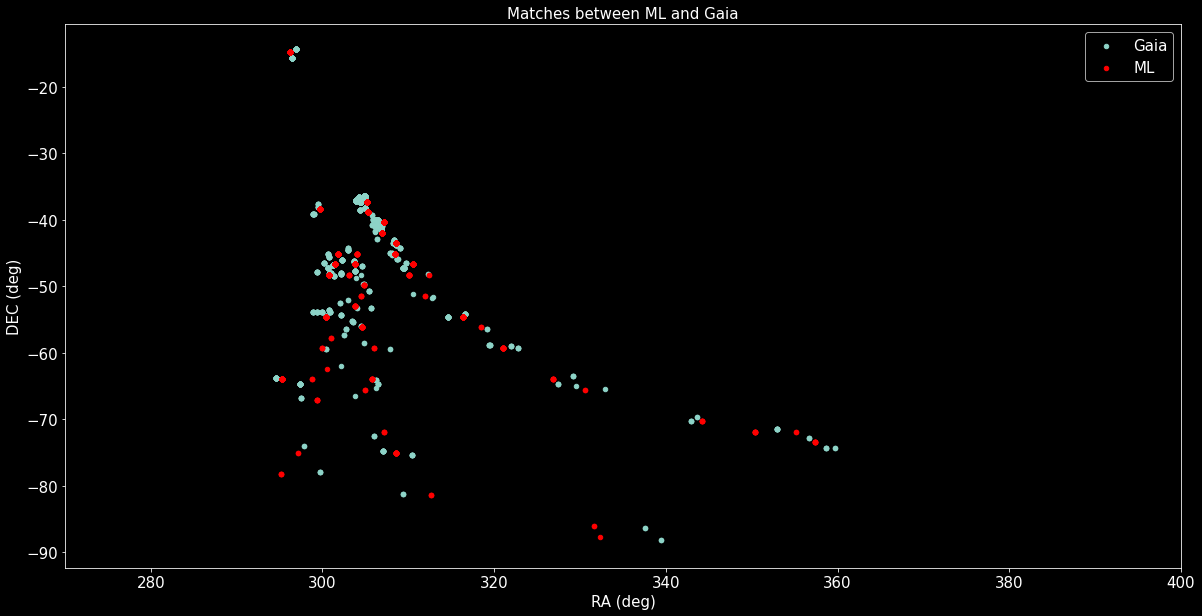

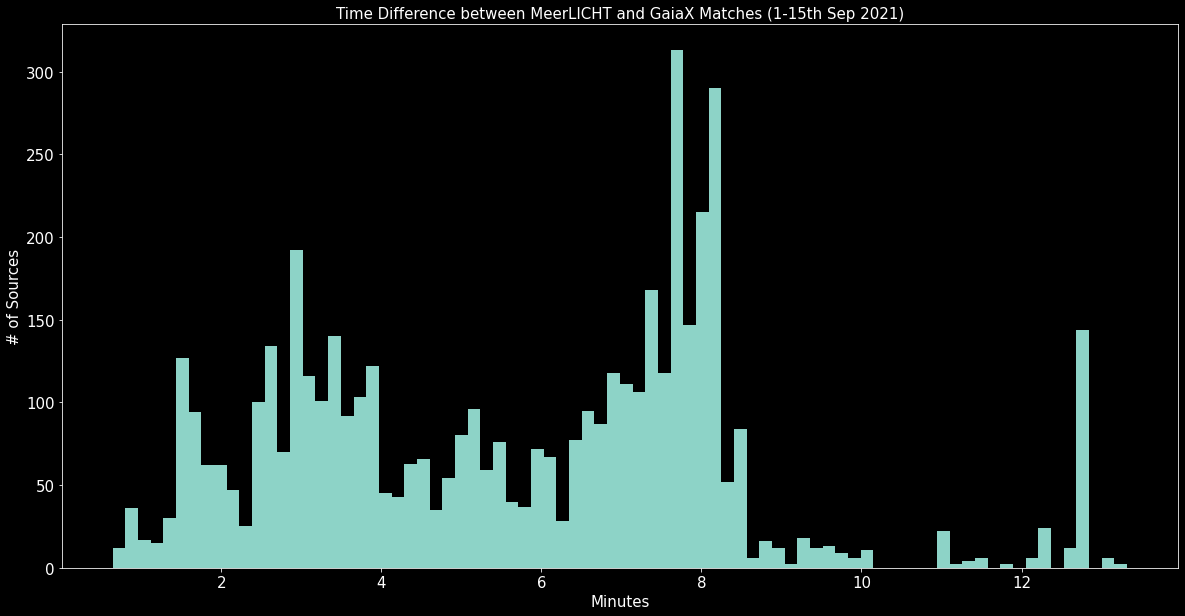

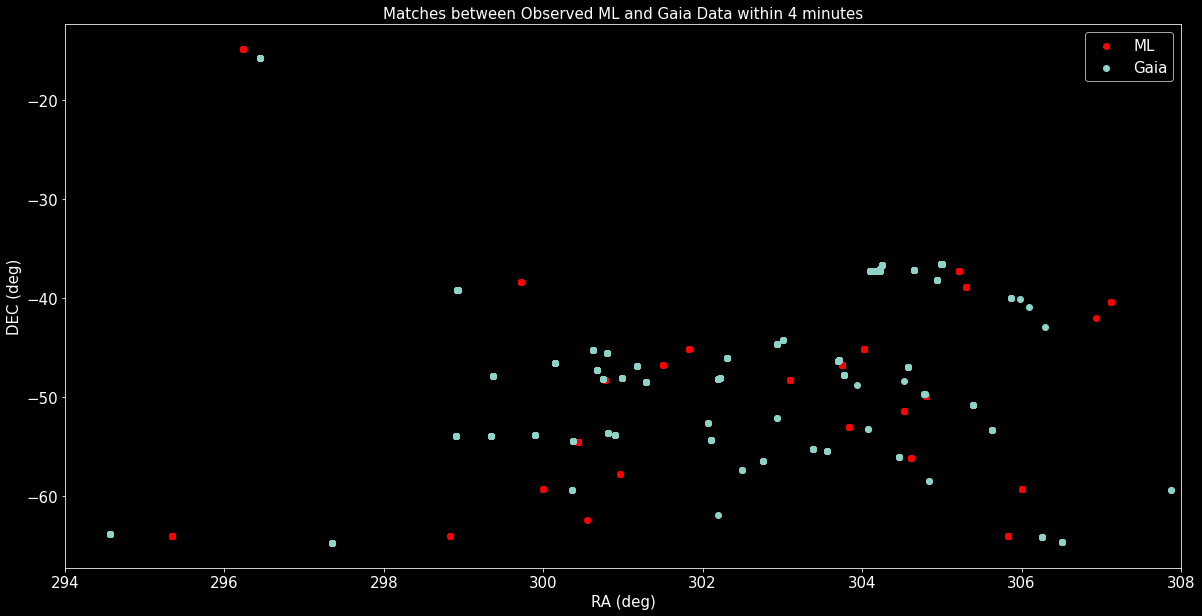

In [9]:
# Various Plots

plt.figure(figsize=(20, 10))
plt.scatter(gaia_matches['RA'], gaia_matches['Dec'], s=20, label="Gaia")
plt.scatter(ml_matches['RA'], ml_matches['DEC'], s=20, label="ML", c='r')
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([270, 400])
# plt.ylim([25, 50])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches between ML and Gaia', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig('/home/sumedha/Documents/Gaia-ML-Expt/1_to_15_sep/matches_zoomed.pdf')
plt.show()

plt.figure(figsize=(20, 10))
plt.hist(timediff, bins=80)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Time Difference between MeerLICHT and GaiaX Matches (1-15th Sep 2021)', fontsize=15)
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('# of Sources', fontsize=15)
plt.savefig('/home/sumedha/Documents/Gaia-ML-Expt/1_to_15_sep/timediff.pdf')
plt.show()

plt.figure(figsize=(20, 10))
plt.scatter(matches_data[mask]['RA_ML'], matches_data[mask]['DEC_ML'], label="ML", c='r')
plt.scatter(matches_data[mask]['RA_Gaia'], matches_data[mask]['DEC_Gaia'], label="Gaia")
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([294, 308])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches between Observed ML and Gaia Data within 4 minutes', fontsize=15)
plt.legend(fontsize=15)
plt.show()

Text(0, 0.5, 'DEC (deg)')

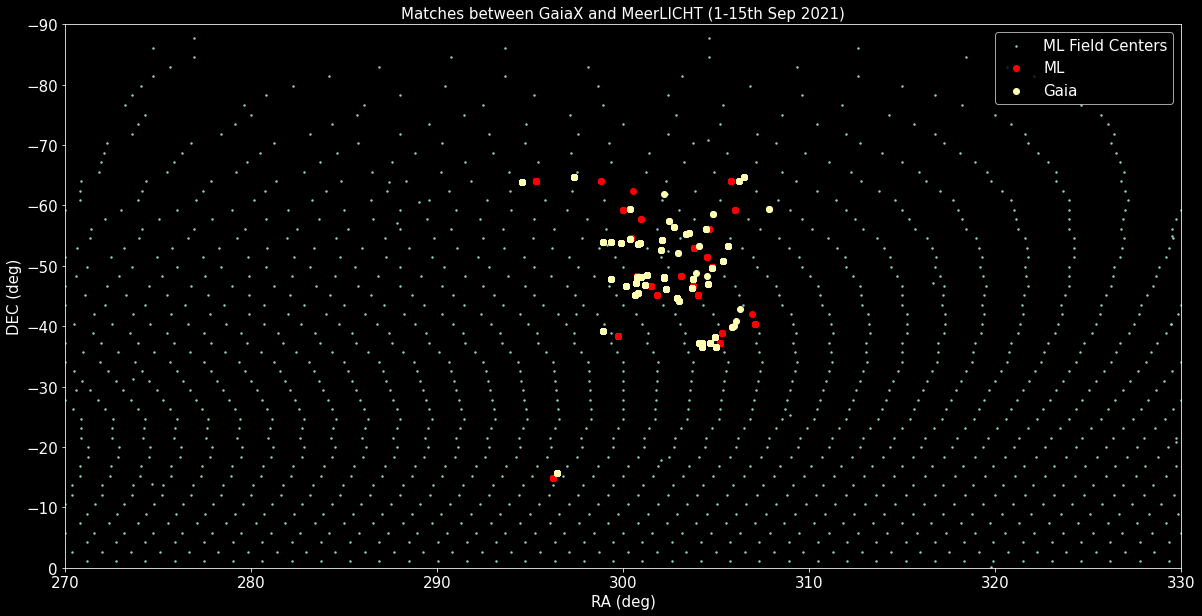

In [20]:
mlbg_ids.remove_row(0)
mlbg_ids['ra'] = mlbg_ids['ra'].astype(float)
mlbg_ids['dec'] = mlbg_ids['dec'].astype(float)

plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers')
plt.scatter(matches_data[mask]['RA_ML'], matches_data[mask]['DEC_ML'], label="ML", c='r')
plt.scatter(matches_data[mask]['RA_Gaia'], matches_data[mask]['DEC_Gaia'], label="Gaia")
plt.xticks(fontsize=15) #, rotation=50)
plt.xlim([270, 330])
plt.ylim([0, -90])
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Matches between GaiaX and MeerLICHT (1-15th Sep 2021)', fontsize=15)
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)

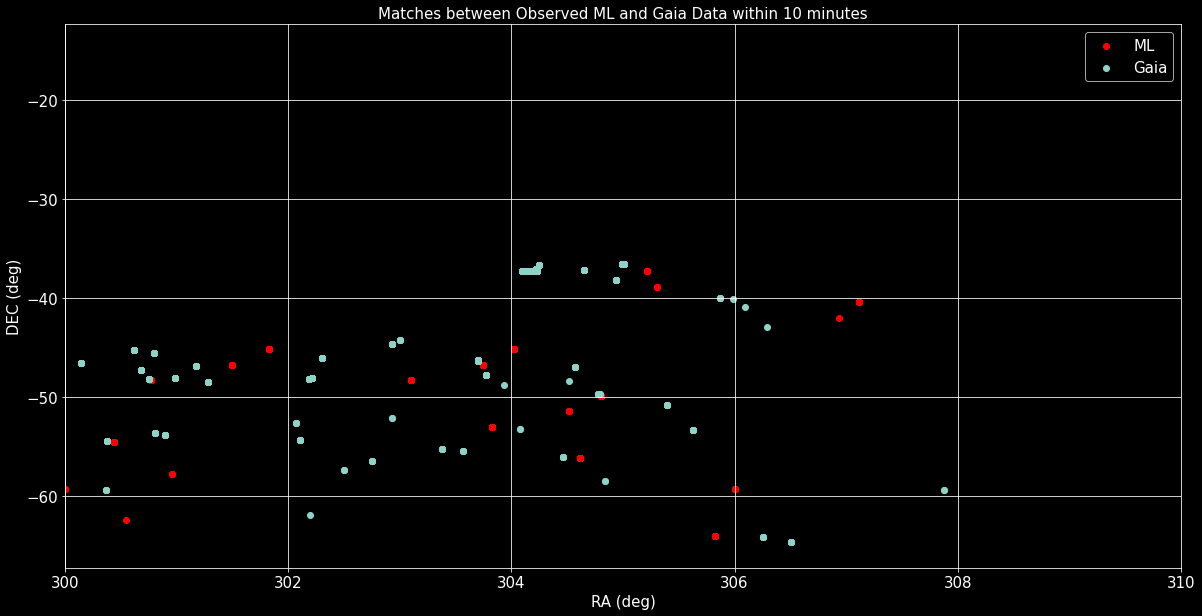

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(matches_data[mask]['RA_ML'], matches_data[mask]['DEC_ML'], label="ML", c='r') #, alpha=0.05)
plt.scatter(matches_data[mask]['RA_Gaia'], matches_data[mask]['DEC_Gaia'], label="Gaia") #, alpha=0.05)
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([300, 310])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches between Observed ML and Gaia Data within 10 minutes', fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

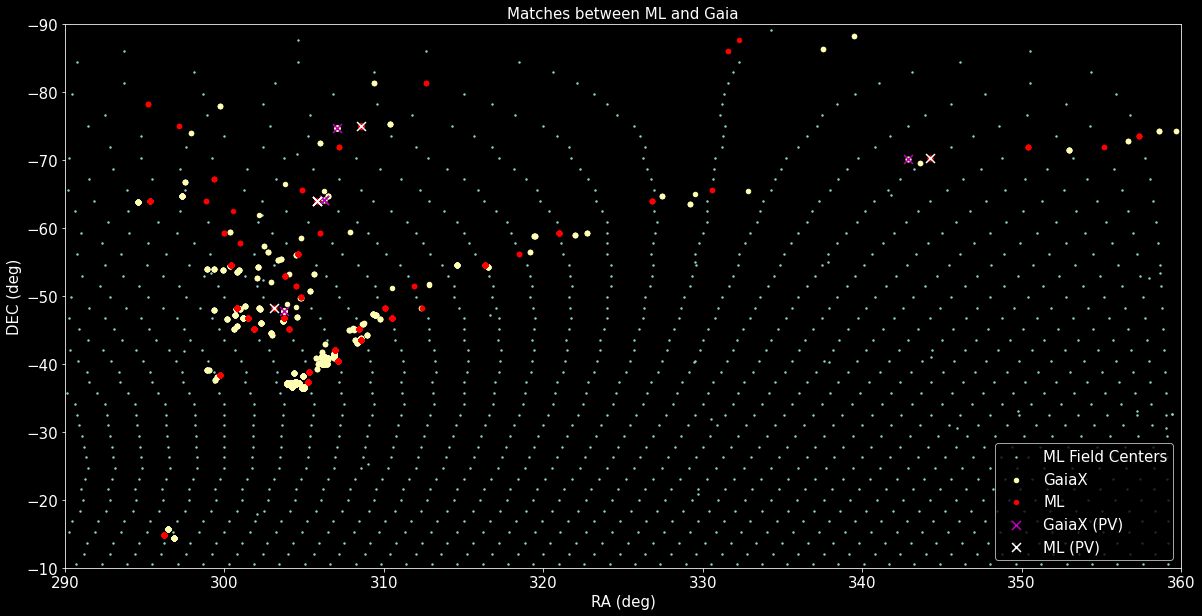

In [11]:
# Paul's matched data

paul_matched_data = fits.getdata('/home/sumedha/Documents/Gaia-ML-Expt/1_to_15_sep/matched_data_10min_paul.fits', 1)
t = Table(paul_matched_data)
fits.writeto('paul_matched_data.fits', np.array(t), overwrite=True)

mlbg_ids.remove_row(0)
mlbg_ids['ra'] = mlbg_ids['ra'].astype(float)
mlbg_ids['dec'] = mlbg_ids['dec'].astype(float)

plt.figure(figsize=(20, 10))
plt.scatter(mlbg_ids['ra'], mlbg_ids['dec'], s=2, label='ML Field Centers')
plt.scatter(gaia_matches['RA'], gaia_matches['Dec'], s=20, label="GaiaX")
plt.scatter(ml_matches['RA'], ml_matches['DEC'], s=20, label="ML", c='r')
plt.scatter(t['RA_Gaia'], t['DEC_Gaia'], s=80, label="GaiaX (PV)", c='m', marker='x')
plt.scatter(t['RA_ML'], t['DEC_ML'], s=80, label="ML (PV)", c='w', marker='x')
plt.xticks(fontsize=15) #, rotation=50)
plt.yticks(fontsize=15)
plt.xlim([290, 360])
plt.ylim([-10, -90])
plt.xlabel('RA (deg)', fontsize=15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Matches between ML and Gaia', fontsize=15)
plt.legend(fontsize=15, loc=4)
# plt.savefig('/home/sumedha/Documents/Gaia-ML-Expt/1_to_15_sep/matches_zoomed.pdf')
plt.show()

In [12]:
t
# GaiaX21-117403,6384320709139048064,2021-09-04T23:03:02,342.903408,-70.199231,19.52,0.0

Name,SourceID,ObsTime_Gaia,RA_Gaia,DEC_Gaia,GMag,GMagErr,ID,File name,Field ID,Filter,ObsTime_ML,Exposure time [s],trans,objects,TQC flag,RA_ML,DEC_ML,timediff,NUMBER,X_PEAK,Y_PEAK,RA_PEAK,DEC_PEAK,SNR_ZOGY,E_FLUX_ZOGY,E_FLUXERR_ZOGY,MAG_ZOGY,MAGERR_ZOGY,X_POS_SCORR,Y_POS_SCORR,RA_SCORR,DEC_SCORR,ELONG_SCORR,FLAGS_SCORR,FLAGS_MASK_SCORR,X_PSF_D,XERR_PSF_D,Y_PSF_D,YERR_PSF_D,RA_PSF_D,DEC_PSF_D,MAG_PSF_D,MAGERR_PSF_D,CHI2_PSF_D,X_GAUSS_D,XERR_GAUSS_D,Y_GAUSS_D,YERR_GAUSS_D,RA_GAUSS_D,DEC_GAUSS_D,FWHM_GAUSS_D,ELONG_GAUSS_D,CHI2_GAUSS_D,CLASS_REAL,"THUMBNAIL_RED [100,100]","THUMBNAIL_REF [100,100]","THUMBNAIL_D [100,100]","THUMBNAIL_SCORR [100,100]",REDFILE,MJD-OBS,OBJECT,FILTER,EXPTIME,S-SEEING,AIRMASS,QC-FLAG,separation,dtime
str14,int64,float64,float64,float64,float64,float64,int64,str23,int64,str1,float64,float64,int64,int64,str6,float64,float64,float64,int32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,str23,float64,str5,str1,float64,float64,float64,str6,float64,float64
GaiaX21-117403,6384320709139048064,59461.960439814815,342.903408,-70.199231,19.52,0.0,69163,ML1_20210914_174305_red,16133,q,59471.73825293982,60.0,3016,22907,red,344.25,-70.32684,9.777813125001558,87,6629,8421,342.9035399513868,-70.19912624209125,8.734531,26.834864,2.978251,19.83121,0.12049977,6628.1094,8421.234,342.90342276639393,-70.19926487017995,1.2089448,0,0,6628.2954,0.21094592,8421.072,0.21087672,342.90349932605704,-70.19923623471554,19.801207,0.092196375,0.7138891,6628.126,0.23307088,8421.542,0.2905987,342.9032807725521,-70.19926125752391,5.410593,1.330267,0.71562594,0.000190569,5.1324234 .. 48.735565,4.3528237 .. 60.174072,-11.321536 .. -23.014557,0.8826902 .. -1.9587277,ML1_20210904_225824_red,59461.95722723268,00569,q,60.0,2.085940701746941,1.267902624845705,yellow,1.3010383225137723,0.003212582138075959
GaiaX21-118564,6669147993723640832,59465.98322916667,303.769813,-47.770473,19.52,0.02,68934,ML1_20210911_172242_red,16038,q,59468.72410481481,60.0,204,65040,yellow,303.09677,-48.2929,2.7408756481454475,35,9014,2250,303.76963327643307,-47.77039930963074,7.7618327,27.88799,3.606557,19.458807,0.14041059,9013.112,2251.1108,303.7693772956252,-47.770538776702445,1.1475086,0,0,9013.908,0.36839804,2249.8232,0.3817026,303.7696745875221,-47.77041343286084,19.476622,0.13565576,1.0010828,9011.804,0.3497914,2252.1753,0.28035277,303.76913311639146,-47.770744021277885,4.279349,1.382165,1.0077715,0.07913875,-10.709427 .. 5.6748657,-8.083733 .. 5.1786194,18.778965 .. 5.144883,-0.29157293 .. -0.45919847,ML1_20210908_233000_red,59465.9791673899,02254,q,60.0,3.154548243618012,1.434563844999175,yellow,1.1415971190469838,0.0040617767663206905
GaiaX21-118560,6372634309285338496,59465.96289351852,307.085124,-74.795549,20.12,0.02,69197,ML1_20210914_182759_red,16100,q,59471.76943761574,60.0,6883,183182,yellow,308.57144,-75.0484,5.806544097220467,632,7333,8049,307.0848802165388,-74.79552571493345,7.1181474,23.464542,3.4271307,19.846579,0.15857798,7331.9683,8048.3794,307.08523212835763,-74.79568965212819,1.1152585,0,0,7332.229,0.42459595,8048.537,0.4585089,307.0851426634181,-74.79564822656893,19.795618,0.14978024,1.0745165,7332.5537,0.0,8048.701,0.0,307.08505066370844,-74.79559674892232,4.8795066,1.0687147,1.0890089,0.1723802,-3.5396576 .. 5.3389664,5.9124737 .. -5.917679,0.5076957 .. 31.6361,1.3427342 .. -1.3391191,ML1_20210908_230323_red,59465.96068645158,00340,q,60.0,3.211437649822235,1.492069367395397,orange,1.2517439885856654,0.0022070669365348294
GaiaX21-118543,6429547195803220224,59465.897002314814,306.256554,-64.118162,19.87,0.02,69115,ML1_20210911_230547_red,16020,u,59468.96235875,60.0,20,3410,orange,305.82523,-64.03143,3.0653564351887326,55,5182,4126,306.25664101273617,-64.11821583915236,8.492758,32.44085,3.76420

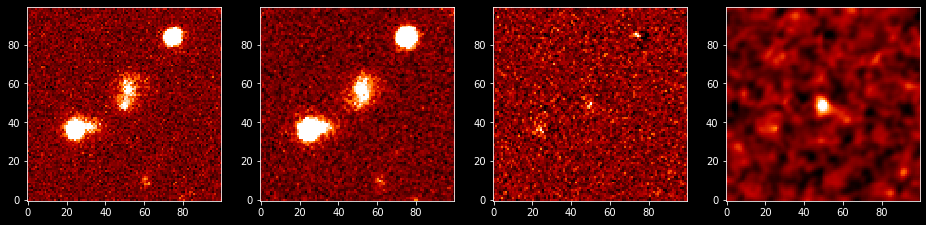

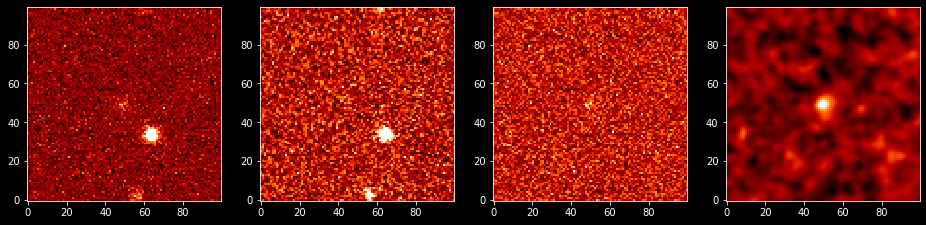

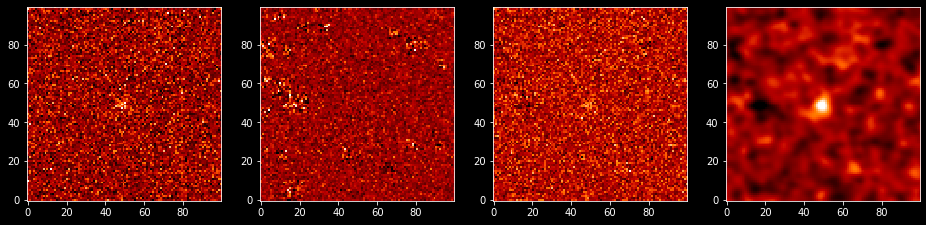

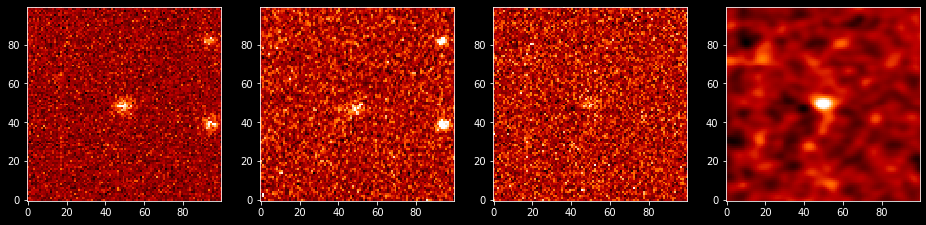

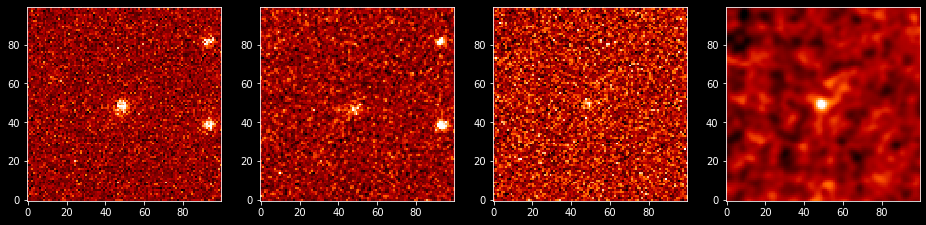

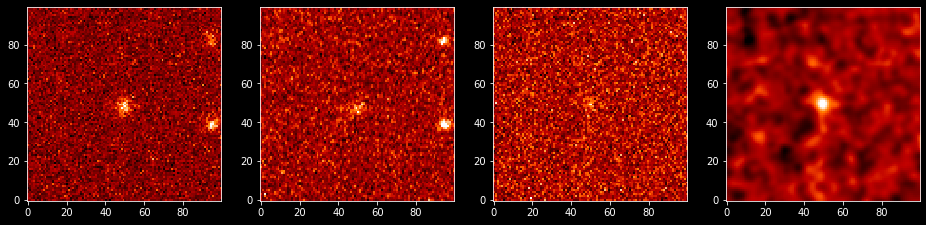

In [13]:
# Generating images for the matches (from Paul V)

def show_thumbs (data_row):
        
    fig=plt.figure(figsize=(16,7))
    ncols, nrows = 4, 1
    fields2show = ['THUMBNAIL_RED', 'THUMBNAIL_REF',
                   'THUMBNAIL_D', 'THUMBNAIL_SCORR']
    for ip in range (len(fields2show)):
        data = data_row[fields2show[ip]]
        vmin, vmax = zscale().get_limits(data)
        fig.add_subplot(nrows, ncols, ip+1)
        plt.imshow(data, vmin=vmin, vmax=vmax,
                   interpolation='none', cmap='gist_heat',
                   origin='lower')

    plt.show()
    plt.close()
    
for i in range(0, len(t)):
    show_thumbs(t[i])
# zoomed in plot?

In [22]:
# all_gaia_data